# Compare Full/Randomized SVD performance on CPU/GPU 

This benchmark evaluates Singular Value Decomposition (SVD) performance utilized in truncation of:
1. 3D tensors 
2. Binary tree tensor networks (TTNs)

The study compares four distinct computational modes:

## 1. CPU Full SVD
- Implementation: Standard numpy.linalg.svd implementation
- Computes complete decomposition with all singular values/vectors
- Computational complexity: O(min(mn², m²n)) for m×n matrix

## 2. CPU Randomized SVD
- Implementation: randomized algorithm with power iterations to approximate SVD (https://arxiv.org/abs/0909.4061)
- Significantly reduced computational complexity for large-scale problems 
- Memory efficient - only stores k singular values/vectors
- complexity: O(mnk) for rank-k approximation

## 3. GPU Full SVD
- Implementation: cupy implementation of CPU Full
- Trade-offs:
  - Memory transfer overhead between CPU and GPU
  - Most effective for large matrices

## 4. GPU Randomized SVD
Randomized SVD transforms costly matrix-vector operations into matrix-matrix operations which are more
optimized for GPU's vector processing units, moreover, the initial random projection operation is embarrassingly parallel. So we can expect good scaling with number of parallel processors. 
- Implementation: cupy implementation of CPU Randomized
- Trade-offs:
  - Slightly lower accuracy than full SVD
  - Memory transfer overhead

# Benchmark Setup

In [11]:
from typing import Tuple
import numpy as np
from copy import deepcopy, copy
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from time import perf_counter
from pytreenet.util.tensor_splitting import tensor_svd
from pytreenet.gpu_config import enable_gpu_acceleration, disable_gpu_acceleration, GPUConfig
from pytreenet.random.random_ttn import _generate_hosvd_tensor
from pytreenet.util.tensor_splitting import tensor_matricization, _determine_tensor_shape, SplitMode
from pytreenet.core.truncation.truncation import TruncationMode
from pytreenet.random.random_ttn import generate_random_ttn
from pytreenet.ttns.ttns import TreeTensorNetworkState
from pytreenet.util.tensor_splitting import SVDParameters
from pytreenet.special_ttn import generate_binary_ttns
from pytreenet.core.truncation.truncation_util import (get_truncation_projector,
                                                        insert_child_projection_operator_and_conjugate,
                                                        contract_projectors)

# Tensor Truncation

def randomized_svd(matrix, k, n_iter=2, random_state=None):
    """
    Rank-k approximation of matrix using randomized SVD with power iterations.

    Args:
        matrix : array_like, shape (m, n)
            Input matrix (real or complex)
        k : int
            Target rank for the approximation (must be ≤ min(m, n))
        n_iter : int, default=4
            Number of power iterations (≥ 0)
        random_state : int, optional
            Seed for random number generation

    Returns:
        U_k : ndarray, shape (m, k)
            Left singular vectors
        s_k : ndarray, shape (k,)
            Singular values (sorted in descending order)
        Vh_k : ndarray, shape (k, n)
            Conjugate transpose of right singular vectors

    """
    m, n = matrix.shape
    max_rank = min(m, n)
    
    if k > max_rank:
        raise ValueError(
            f"Target rank k={k} exceeds maximum possible rank {max_rank} "
            f"for matrix shape {matrix.shape}")

    # NO OVERSAMPLING: ℓ = k exactly
    # This guarantees ℓ ≤ min(m, n) whenever k ≤ min(m, n)
    ell = k

    # Set up random number generator
    rng = np.random.RandomState(random_state)

    # Generate random matrix Ω ∈ ℝ^(n×k) or ℂ^(n×k)
    if np.iscomplexobj(matrix):
        # Complex case: Gaussian entries with real and imaginary parts
        Omega = (rng.randn(n, ell) + 1j * rng.randn(n, ell)).astype(matrix.dtype)
    else:
        # Real case: Standard Gaussian entries
        Omega = rng.randn(n, ell).astype(matrix.dtype)

    # ALGORITHM : Randomized SVD with q power iterations
    
    # Step 1-3: Initial range finding
    Y0 = matrix @ Omega                    # Y₀ = AΩ
    Q, _ = np.linalg.qr(Y0, mode='reduced') # [Q₀, R₀] = qr(Y₀)

    # Steps 4-9: Power iterations (if n_iter > 0)
    for iteration in range(n_iter):
        # Step 5: Ỹⱼ ← A† Qⱼ₋₁
        Y_hat = matrix.conj().T @ Q
        
        # Step 6: [Q̃ⱼ, R̃ⱼ] ← qr(Ỹⱼ)  
        Q_hat, _ = np.linalg.qr(Y_hat, mode='reduced')
        
        # Step 7: Yⱼ ← AQ̃ⱼ
        Y = matrix @ Q_hat
        
        # Step 8: [Qⱼ, Rⱼ] ← qr(Yⱼ)
        Q, _ = np.linalg.qr(Y, mode='reduced')

    # Steps 10-14: Final factorization
    # Step 11: B ← Q† A
    B = Q.conj().T @ matrix
    
    # Step 12: [Ũ, Σ, Ṽ†] ← svd(B)
    U_tilde, s, Vh = np.linalg.svd(B, full_matrices=False)
    
    # Step 13: U ← QŨ  
    U = Q @ U_tilde
    
    # Step 14: Return rank-k approximation
    # Since ℓ = k, we get exactly k singular values (no truncation needed!)
    U_k = U[:, :k]
    s_k = s[:k] 
    Vh_k = Vh[:k, :]

    return U_k, s_k, Vh_k

def cpu_randomized_svd(tensor: np.ndarray,
                        u_legs: Tuple[int,...],
                        v_legs: Tuple[int,...],
                        randomized_cutoff: int = float("inf")) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:

    correctly_ordered = u_legs + v_legs == list(range(len(u_legs) + len(v_legs)))
    matrix = tensor_matricization(tensor, u_legs, v_legs,
                                  correctly_ordered=correctly_ordered)

    u, s, vh = randomized_svd(matrix, randomized_cutoff, 2)

    shape = tensor.shape
    u_shape = _determine_tensor_shape(shape, u, u_legs, output=True)
    vh_shape = _determine_tensor_shape(shape, vh, v_legs, output=False)
    u = u.reshape(u_shape)
    vh = vh.reshape(vh_shape)
    return u, s, vh

# Tree Truncation

def svd_recursive_truncate(node_id: str,
                    tree: TreeTensorNetworkState,
                    svd_params: SVDParameters):
    """
    Truncates the children of the node with the given id.

    Args:
        node_id (str): The id of the node to truncate.

    """
    node = tree.nodes[node_id]
    orig_children = copy(node.children)
    for child_id in orig_children:
        projector, _ = get_truncation_projector(node,
                                            tree.tensors[node_id],
                                            child_id,
                                            svd_params)
        insert_child_projection_operator_and_conjugate(child_id,
                                                    node_id,
                                                    projector,
                                                    tree)

    contract_projectors(tree, node_id, contract_parent = False)

    # This makes the former children, the new children
    for child_id in orig_children:
        svd_recursive_truncate(child_id, tree, svd_params)
    return tree

def compute_error(ttns_ref: TreeTensorNetworkState, ttns_new: TreeTensorNetworkState) -> float:
    return abs(1 - ttns_ref.scalar_product(other=ttns_new))

def truncation_result(ttns: TreeTensorNetworkState,
                     svd_params: SVDParameters) -> tuple[float, float, int]:
    """
    Apply truncation using the specified mode and return performance metrics.
    
    Args:
        ttns: The tree tensor network state to truncate
        svd_params: Parameters for SVD truncation
        mode: Truncation mode (GreedyTruncationMode or SVDTruncationMode)
    
    Returns:
        tuple: (error, truncation_time, total_size_diff)
    """
    ttn_copy = deepcopy(ttns)
    start = perf_counter()
    truncated_ttn = svd_recursive_truncate(ttn_copy.root_id, ttn_copy, svd_params)
    end = perf_counter()
    return compute_error(ttns, truncated_ttn), end - start


In [12]:
# Tensor Truncation / k = varied , tensor dimension = fixed 

def svd_test_fix_shape(tensor_shape, target_ranks):
    """
    Test the tensor_svd function in all 4 modes:
    1. CPU + Full SVD 
    2. CPU + Randomized SVD
    3. GPU + Full SVD
    4. GPU + Randomized SVD
    """    
    # Check GPU availability
    config = GPUConfig()
    gpu_available = config.is_gpu_available()
    print(f" GPU Available: {gpu_available}")
    
    results = []
    
    size = tensor_shape[0] * tensor_shape[1] * tensor_shape[2]
    print(f"Testing tensor size: {size:,} elements")

    # Generate a random tensor with specified shape
    tensor = _generate_hosvd_tensor(
        shape=tensor_shape,
        large_scale=1,
        small_scale=1e-4,
        decay_type="power",
        decay_rate=0.5)
    
    tensor_flat = tensor.reshape(-1, tensor_shape[2])
    norm_tensor = np.linalg.norm(tensor_flat)
    
    for k in target_ranks:
        print(f"Testing target rank k = {k}")
        
        test_result = {
            'size': size,
            'tensor_shape': tensor_shape,
            'k': k,
            'times': {},
            'errors': {}
        }
        
        # 1. CPU + Full SVD
        print("🖥️ tensor_svd: CPU + Full SVD")
        disable_gpu_acceleration()
        cpu_reg_tensor = deepcopy(tensor) 
        start_time = time.time()
        U1, s1, Vh1 = tensor_svd(cpu_reg_tensor, u_legs=(0, 1), v_legs=(2,), randomized_cutoff=float('inf'))
        time1 = time.time() - start_time
        test_result['times']['cpu_full'] = time1
        print(f"        Time: {time1:.4f}s")
        
        # Truncate to target rank k for fair comparison
        min_rank = min(U1.shape[-1], Vh1.shape[0], len(s1))
        trunc_k = min(k, min_rank)
        U1_trunc = U1[..., :trunc_k]
        s1_trunc = s1[:trunc_k]
        Vh1_trunc = Vh1[:trunc_k, ...]
        
        # Calculate error for Full (truncated)
        U1_matrix = U1_trunc.reshape(-1, U1_trunc.shape[-1])
        Vh1_matrix = Vh1_trunc.reshape(Vh1_trunc.shape[0], -1)
        reconstructed = U1_matrix @ np.diag(s1_trunc) @ Vh1_matrix
        error1 = np.linalg.norm(tensor_flat - reconstructed) / norm_tensor
        test_result['errors']['cpu_full'] = error1
        print(f"        Reconstruction Error: {error1:.2e}")
        
        # 2. CPU + Randomized SVD  
        print("🎲 tensor_svd: CPU + Randomized SVD")
        disable_gpu_acceleration()
        cpu_rand_tensor = deepcopy(tensor) 
        start_time = time.time()
        U2, s2, Vh2 = cpu_randomized_svd(cpu_rand_tensor, u_legs=(0, 1), v_legs=(2,), randomized_cutoff=k)
        time2 = time.time() - start_time
        test_result['times']['cpu_randomized'] = time2
        print(f"        Time: {time2:.4f}s")
        print(f"        Speedup: {time1/time2:.2f}x")
        
        # Calculate error for randomized
        U2_matrix = U2.reshape(-1, U2.shape[-1])
        Vh2_matrix = Vh2.reshape(Vh2.shape[0], -1)
        reconstructed = U2_matrix @ np.diag(s2) @ Vh2_matrix
        error2 = np.linalg.norm(tensor_flat - reconstructed) / norm_tensor
        test_result['errors']['cpu_randomized'] = error2
        print(f"        Reconstruction Error: {error2:.2e}")
        
        # 3. GPU + Full SVD (if available)
        print("🚀 tensor_svd: GPU + Full SVD")
        enable_gpu_acceleration(threshold=0, verbose=True)
        gpu_reg_tensor = deepcopy(tensor) 
        start_time = time.time()
        U3, s3, Vh3 = tensor_svd(gpu_reg_tensor, u_legs=(0, 1), v_legs=(2,), randomized_cutoff=float('inf'))
        time3 = time.time() - start_time
        test_result['times']['gpu_full'] = time3
        print(f"        Time: {time3:.4f}s")
        print(f"        GPU Speedup: {time1/time3:.2f}x")
        
        # Truncate to target rank k for fair comparison
        min_rank = min(U3.shape[-1], Vh3.shape[0], len(s3))
        trunc_k = min(k, min_rank)
        U3_trunc = U3[..., :trunc_k]
        s3_trunc = s3[:trunc_k]
        Vh3_trunc = Vh3[:trunc_k, ...]
        
        # Calculate error for GPU Full (truncated)
        U3_matrix = U3_trunc.reshape(-1, U3_trunc.shape[-1])
        Vh3_matrix = Vh3_trunc.reshape(Vh3_trunc.shape[0], -1)
        reconstructed_gpu_reg = U3_matrix @ np.diag(s3_trunc) @ Vh3_matrix
        error3 = np.linalg.norm(tensor_flat - reconstructed_gpu_reg) / norm_tensor
        test_result['errors']['gpu_full'] = error3
        print(f"        Reconstruction Error: {error3:.2e}")
        
        # 4. GPU + Randomized SVD
        print("🎲🚀 tensor_svd: GPU + Randomized SVD")
        enable_gpu_acceleration(threshold=0, verbose=True)
        gpu_rand_tensor = deepcopy(tensor) 
        start_time = time.time()
        U4, s4, Vh4 = tensor_svd(gpu_rand_tensor, u_legs=(0, 1), v_legs=(2,), randomized_cutoff=k)
        time4 = time.time() - start_time
        test_result['times']['gpu_randomized'] = time4
        print(f"        Time: {time4:.4f}s")
        print(f"        GPU Speedup: {time2/time4:.2f}x")
        
        # Calculate error for GPU randomized
        U4_matrix = U4.reshape(-1, U4.shape[-1])  # Flatten all but last dimension
        Vh4_matrix = Vh4.reshape(Vh4.shape[0], -1)  # Flatten all but first dimension
        reconstructed_gpu = U4_matrix @ np.diag(s4) @ Vh4_matrix
        error4 = np.linalg.norm(tensor_flat - reconstructed_gpu) / norm_tensor
        test_result['errors']['gpu_randomized'] = error4
        print(f"        Reconstruction Error: {error4:.2e}")

        results.append(test_result)
    
    # Generate plots
    plots_fix_shape(results, gpu_available)
    return results

def plots_fix_shape(results, gpu_available):
    ks = [r['k'] for r in results]
    
    # Create plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('tensor_svd Performance Analysis - All 4 Modes', fontsize=14, fontweight='bold')
    
    # Plot 1: Time Comparison
    ax1.set_title('Execution Time Comparison', fontweight='bold')
    cpu_full_times = [r['times']['cpu_full'] for r in results]
    cpu_rand_times = [r['times']['cpu_randomized'] for r in results]
    
    ax1.plot(ks, cpu_full_times, 'o-', label='CPU + Full SVD', linewidth=2, markersize=8, color='blue')
    ax1.plot(ks, cpu_rand_times, 's-', label='CPU + Randomized SVD', linewidth=2, markersize=8, color='green')
    
    if gpu_available:
        gpu_full_times = [r['times'].get('gpu_full', None) for r in results]
        gpu_rand_times = [r['times'].get('gpu_randomized', None) for r in results]
        
        valid_gpu_reg_ks = [k for k, t in zip(ks, gpu_full_times) if t is not None]
        valid_gpu_reg_times = [t for t in gpu_full_times if t is not None]
        if valid_gpu_reg_times:
            ax1.plot(valid_gpu_reg_ks, valid_gpu_reg_times, 'o--', 
                     label='GPU + Full SVD', linewidth=2, markersize=8, color='red')
        
        valid_gpu_rand_ks = [k for k, t in zip(ks, gpu_rand_times) if t is not None]
        valid_gpu_rand_times = [t for t in gpu_rand_times if t is not None]
        if valid_gpu_rand_times:
            ax1.plot(valid_gpu_rand_ks, valid_gpu_rand_times, 's--', 
                     label='GPU + Randomized SVD', linewidth=2, markersize=8, color='orange')
    
    ax1.set_xlabel('Target Rank k')
    ax1.set_ylabel('Time (seconds)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_yscale('log')
    
    # Plot 2: Randomized speedup: CPU vs GPU
    ax2.set_title('Randomized Speedup: CPU vs GPU', fontweight='bold')
    
    cpu_speedups = [r['times']['cpu_full'] / r['times']['cpu_randomized'] for r in results]
    ax2.plot(ks, cpu_speedups, 'o-', label='CPU Speedup', linewidth=2, markersize=8, color='green')
    
    if gpu_available:
        gpu_speedups = []
        valid_ks_gpu = []
        for i, r in enumerate(results):
            if 'gpu_full' in r['times'] and 'gpu_randomized' in r['times']:
                gpu_speedups.append(r['times']['gpu_full'] / r['times']['gpu_randomized'])
                valid_ks_gpu.append(ks[i])
        if gpu_speedups:
            ax2.plot(valid_ks_gpu, gpu_speedups, 's--', 
                     label='GPU Speedup', linewidth=2, markersize=8, color='orange')
    
    ax2.set_xlabel('Target Rank k')
    ax2.set_ylabel('Speedup Factor')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.axhline(y=1, color='black', linestyle=':', alpha=0.5)
    
    # Plot 3: GPU Speedup: Full vs Randomized
    if gpu_available:
        ax3.set_title('GPU Speedup: Full vs Randomized', fontweight='bold')
        
        gpu_full_speedups = []
        valid_ks_reg = []
        for i, r in enumerate(results):
            if 'gpu_full' in r['times']:
                speedup = r['times']['cpu_full'] / r['times']['gpu_full']
                if speedup > 0:  # Avoid division issues
                    gpu_full_speedups.append(speedup)
                    valid_ks_reg.append(ks[i])
        
        gpu_rand_speedups = []
        valid_ks_rand = []
        for i, r in enumerate(results):
            if 'gpu_randomized' in r['times']:
                speedup = r['times']['cpu_randomized'] / r['times']['gpu_randomized']
                if speedup > 0:
                    gpu_rand_speedups.append(speedup)
                    valid_ks_rand.append(ks[i])
        
        if gpu_full_speedups:
            ax3.plot(valid_ks_reg, gpu_full_speedups, 'o-', 
                     label='full SVD', linewidth=2, markersize=8, color='blue')
        if gpu_rand_speedups:
            ax3.plot(valid_ks_rand, gpu_rand_speedups, 's-', 
                     label='Randomized SVD', linewidth=2, markersize=8, color='green')
        
        ax3.set_xlabel('Target Rank k')
        ax3.set_ylabel('GPU Speedup Factor')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        ax3.axhline(y=1, color='black', linestyle=':', alpha=0.5)
    else:
        ax3.text(0.5, 0.5, 'GPU Not Available', transform=ax3.transAxes, 
                 ha='center', va='center', fontsize=16)
        ax3.set_title('GPU Speedup: Full vs Randomized', fontweight='bold')
    
    # Plot 4: Reconstruction Errors
    ax4.set_title('Reconstruction Errors', fontweight='bold')
    
    cpu_reg_errors = [r['errors']['cpu_full'] for r in results]
    cpu_rand_errors = [r['errors']['cpu_randomized'] for r in results]
    ax4.semilogy(ks, cpu_reg_errors, 'o-', label='CPU Full', linewidth=2, markersize=8, color='blue')
    ax4.semilogy(ks, cpu_rand_errors, 's-', label='CPU Randomized', linewidth=2, markersize=8, color='green')
    
    if gpu_available:
        gpu_reg_errors = [r['errors'].get('gpu_full', None) for r in results]
        valid_ks_gpu_reg_err = [k for k, e in zip(ks, gpu_reg_errors) if e is not None]
        valid_gpu_reg_errors = [e for e in gpu_reg_errors if e is not None]
        if valid_gpu_reg_errors:
            ax4.semilogy(valid_ks_gpu_reg_err, valid_gpu_reg_errors, 'o--', 
                         label='GPU Full', linewidth=2, markersize=8, color='red')
        
        gpu_rand_errors = [r['errors'].get('gpu_randomized', None) for r in results]
        valid_ks_gpu_rand_err = [k for k, e in zip(ks, gpu_rand_errors) if e is not None]
        valid_gpu_rand_errors = [e for e in gpu_rand_errors if e is not None]
        if valid_gpu_rand_errors:
            ax4.semilogy(valid_ks_gpu_rand_err, valid_gpu_rand_errors, 's--', 
                         label='GPU Randomized', linewidth=2, markersize=8, color='orange')
    
    ax4.set_xlabel('Target Rank k')
    ax4.set_ylabel('Error')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()


 GPU Available: True
Testing tensor size: 18,000,000 elements
Testing target rank k = 50
🖥️ tensor_svd: CPU + Full SVD
        Time: 5.5664s
        Reconstruction Error: 4.84e-01
🎲 tensor_svd: CPU + Randomized SVD
        Time: 4.7347s
        Speedup: 1.18x
        Reconstruction Error: 4.96e-01
🚀 tensor_svd: GPU + Full SVD
Using GPU SVD for tensor size: 18000000
        Time: 2.6163s
        GPU Speedup: 2.13x
        Reconstruction Error: 4.84e-01
🎲🚀 tensor_svd: GPU + Randomized SVD
Using GPU randomized SVD for tensor size: 18000000
        Time: 2.1976s
        GPU Speedup: 2.15x
        Reconstruction Error: 4.97e-01
Testing target rank k = 100
🖥️ tensor_svd: CPU + Full SVD
        Time: 6.7847s
        Reconstruction Error: 3.36e-01
🎲 tensor_svd: CPU + Randomized SVD
        Time: 9.5964s
        Speedup: 0.71x
        Reconstruction Error: 3.51e-01
🚀 tensor_svd: GPU + Full SVD
Using GPU SVD for tensor size: 18000000
        Time: 2.6311s
        GPU Speedup: 2.58x
        Recon

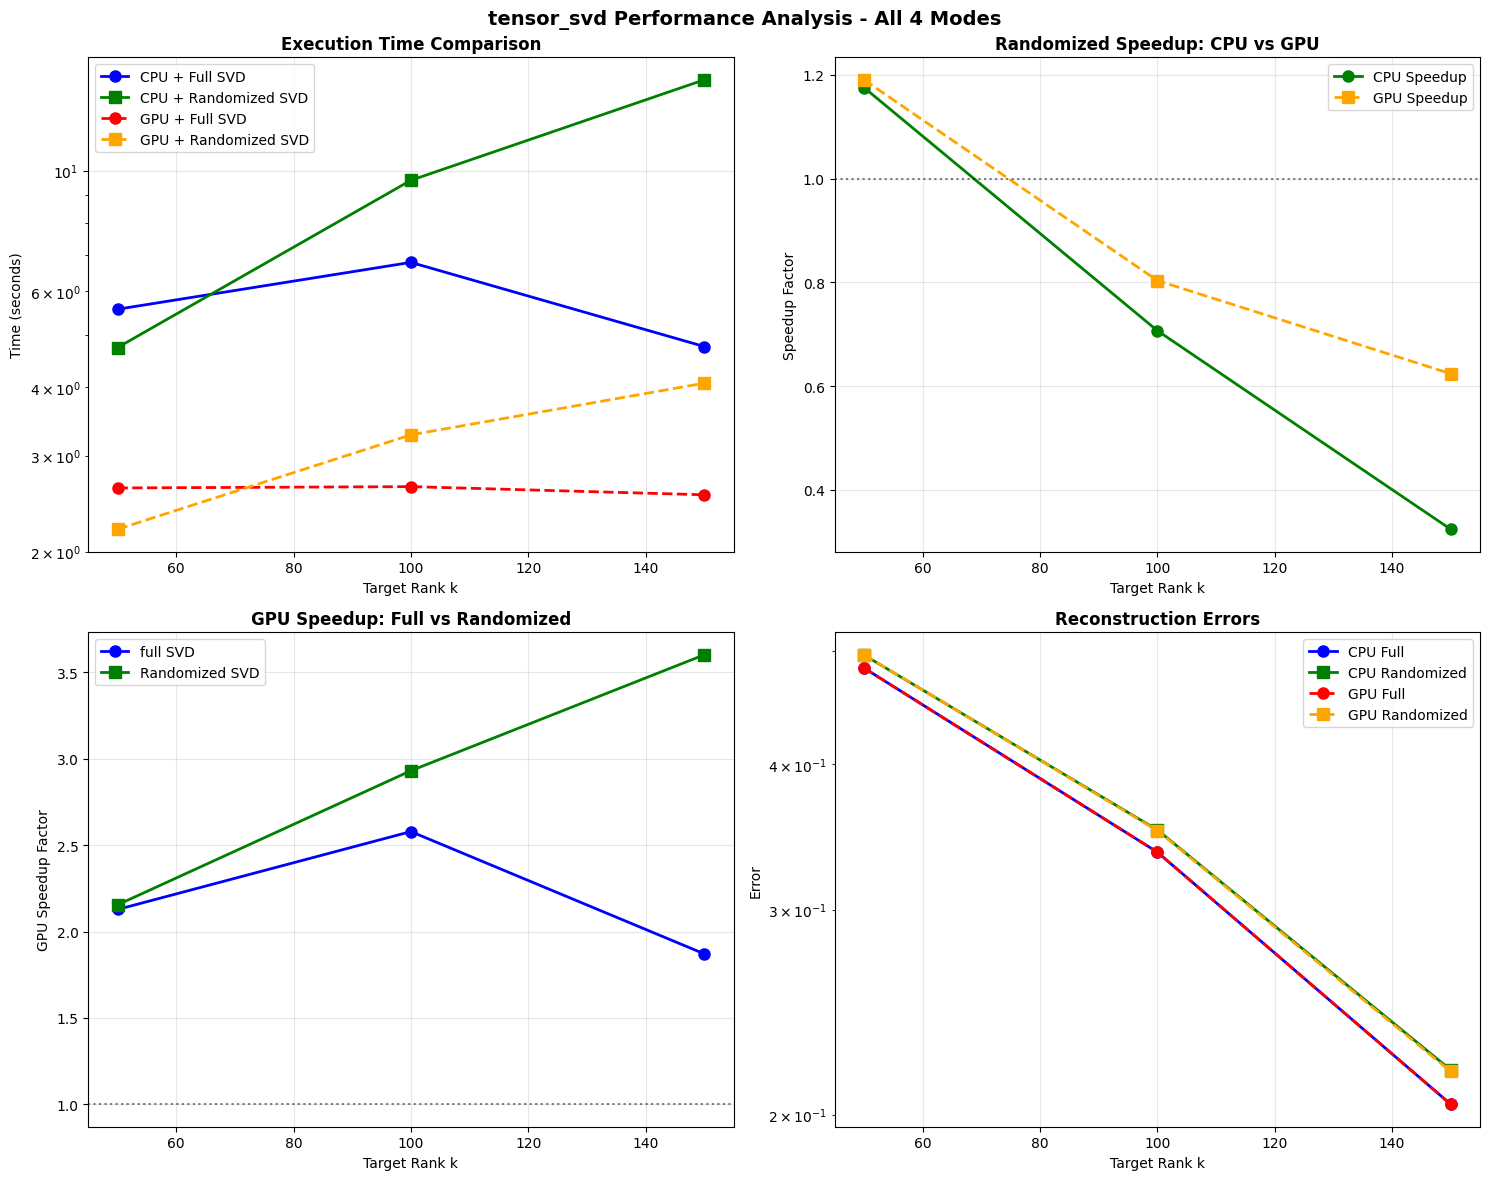

In [13]:
tensor_shape = (300, 300, 200)
target_ranks = [50, 100, 150]
results = svd_test_fix_shape(tensor_shape,target_ranks)

In [14]:
# Tensor Truncation / k = fix , tensor dimension = varied 

def svd_test_fix_rank(tensor_shapes, target_rank):
    """
    Test the tensor_svd function in all 4 modes:
    1. CPU + Full SVD 
    2. CPU + Randomized SVD
    3. GPU + Full SVD
    4. GPU + Randomized SVD
    """    
    # Check GPU availability
    config = GPUConfig()
    gpu_available = config.is_gpu_available()
    print(f" GPU Available: {gpu_available}")

    results = []

    for shape in tensor_shapes:
        size = shape[0] * shape[1] * shape[2]
        print(f"Testing tensor size: {size:,} elements")

        # Generate a random tensor with specified shape
        tensor = _generate_hosvd_tensor(
            shape=shape,
            large_scale=1,
            small_scale=1e-4,
            decay_type="power",
            decay_rate=0.5)
        
        tensor_flat = tensor.reshape(-1, shape[2])
        norm_tensor = np.linalg.norm(tensor_flat)
        
        test_result = {
            'size': size,
            'tensor_shape': shape,
            'times': {},
            'errors': {}
        }
        
        # 1. CPU + Full SVD
        print("🖥️ tensor_svd: CPU + Full SVD")
        disable_gpu_acceleration()
        cpu_reg_tensor = deepcopy(tensor) 
        start_time = time.time()
        U1, s1, Vh1 = tensor_svd(cpu_reg_tensor, u_legs=(0, 1), v_legs=(2,), randomized_cutoff=float('inf'))
        time1 = time.time() - start_time
        test_result['times']['cpu_full'] = time1
        print(f"        Time: {time1:.4f}s")
        
        # Truncate to target rank for fair comparison
        min_rank = min(U1.shape[-1], Vh1.shape[0], len(s1))
        trunc_k = min(target_rank, min_rank)
        U1_trunc = U1[..., :trunc_k]
        s1_trunc = s1[:trunc_k]
        Vh1_trunc = Vh1[:trunc_k, ...]
        
        # Calculate error for Full (truncated)
        U1_matrix = U1_trunc.reshape(-1, U1_trunc.shape[-1])
        Vh1_matrix = Vh1_trunc.reshape(Vh1_trunc.shape[0], -1)
        reconstructed = U1_matrix @ np.diag(s1_trunc) @ Vh1_matrix
        error1 = np.linalg.norm(tensor_flat - reconstructed) / norm_tensor
        test_result['errors']['cpu_full'] = error1
        print(f"        Reconstruction Error: {error1:.2e}")
        
        # 2. CPU + Randomized SVD  
        print("🎲 tensor_svd: CPU + Randomized SVD")
        disable_gpu_acceleration()
        cpu_rand_tensor = deepcopy(tensor) 
        start_time = time.time()
        U2, s2, Vh2 = cpu_randomized_svd(cpu_rand_tensor, u_legs=(0, 1), v_legs=(2,), randomized_cutoff=target_rank)
        time2 = time.time() - start_time
        test_result['times']['cpu_randomized'] = time2
        print(f"        Time: {time2:.4f}s")
        print(f"        Speedup: {time1/time2:.2f}x")
        
        # Calculate error for randomized
        U2_matrix = U2.reshape(-1, U2.shape[-1])
        Vh2_matrix = Vh2.reshape(Vh2.shape[0], -1)
        reconstructed = U2_matrix @ np.diag(s2) @ Vh2_matrix
        error2 = np.linalg.norm(tensor_flat - reconstructed) / norm_tensor
        test_result['errors']['cpu_randomized'] = error2
        print(f"        Reconstruction Error: {error2:.2e}")
        
        # 3. GPU + Full SVD (if available)
        print("🚀 tensor_svd: GPU + Full SVD")
        enable_gpu_acceleration(threshold=0, verbose=True)
        gpu_reg_tensor = deepcopy(tensor) 
        start_time = time.time()
        U3, s3, Vh3 = tensor_svd(gpu_reg_tensor, u_legs=(0, 1), v_legs=(2,), randomized_cutoff=float('inf'))
        time3 = time.time() - start_time
        test_result['times']['gpu_full'] = time3
        print(f"        Time: {time3:.4f}s")
        print(f"        GPU Speedup: {time1/time3:.2f}x")
        
        # Truncate to target rank for fair comparison
        min_rank = min(U3.shape[-1], Vh3.shape[0], len(s3))
        trunc_k = min(target_rank, min_rank)
        U3_trunc = U3[..., :trunc_k]
        s3_trunc = s3[:trunc_k]
        Vh3_trunc = Vh3[:trunc_k, ...]
        
        # Calculate error for GPU Full (truncated)
        U3_matrix = U3_trunc.reshape(-1, U3_trunc.shape[-1])
        Vh3_matrix = Vh3_trunc.reshape(Vh3_trunc.shape[0], -1)
        reconstructed_gpu_reg = U3_matrix @ np.diag(s3_trunc) @ Vh3_matrix
        error3 = np.linalg.norm(tensor_flat - reconstructed_gpu_reg) / norm_tensor
        test_result['errors']['gpu_full'] = error3
        print(f"        Reconstruction Error: {error3:.2e}")
        
        # 4. GPU + Randomized SVD
        print("🎲🚀 tensor_svd: GPU + Randomized SVD")
        enable_gpu_acceleration(threshold=0, verbose=True)
        gpu_rand_tensor = deepcopy(tensor) 
        start_time = time.time()
        U4, s4, Vh4 = tensor_svd(gpu_rand_tensor, u_legs=(0, 1), v_legs=(2,), randomized_cutoff=target_rank)
        time4 = time.time() - start_time
        test_result['times']['gpu_randomized'] = time4
        print(f"        Time: {time4:.4f}s")
        print(f"        GPU Speedup: {time2/time4:.2f}x")
        
        # Calculate error for GPU randomized
        U4_matrix = U4.reshape(-1, U4.shape[-1])  # Flatten all but last dimension
        Vh4_matrix = Vh4.reshape(Vh4.shape[0], -1)  # Flatten all but first dimension
        reconstructed_gpu = U4_matrix @ np.diag(s4) @ Vh4_matrix
        error4 = np.linalg.norm(tensor_flat - reconstructed_gpu) / norm_tensor
        test_result['errors']['gpu_randomized'] = error4
        print(f"        Reconstruction Error: {error4:.2e}")

        results.append(test_result)
    
    # Generate plots
    plots_fix_rank(results, gpu_available)
    return results

def plots_fix_rank(results, gpu_available):
    sizes = [r['size'] for r in results]
    
    # Create plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('tensor_svd Performance Analysis - All 4 Modes', fontsize=14, fontweight='bold')
    
    # Plot 1: Time Comparison
    ax1.set_title('Execution Time Comparison', fontweight='bold')
    cpu_full_times = [r['times']['cpu_full'] for r in results]
    cpu_rand_times = [r['times']['cpu_randomized'] for r in results]
    
    ax1.plot(sizes, cpu_full_times, 'o-', label='CPU + Full SVD', linewidth=2, markersize=8, color='blue')
    ax1.plot(sizes, cpu_rand_times, 's-', label='CPU + Randomized SVD', linewidth=2, markersize=8, color='green')
    
    if gpu_available:
        gpu_full_times = [r['times'].get('gpu_full', None) for r in results]
        gpu_rand_times = [r['times'].get('gpu_randomized', None) for r in results]
        
        valid_gpu_reg_sizes = [s for s, t in zip(sizes, gpu_full_times) if t is not None]
        valid_gpu_reg_times = [t for t in gpu_full_times if t is not None]
        if valid_gpu_reg_times:
            ax1.plot(valid_gpu_reg_sizes, valid_gpu_reg_times, 'o--', 
                     label='GPU + Full SVD', linewidth=2, markersize=8, color='red')
        
        valid_gpu_rand_sizes = [s for s, t in zip(sizes, gpu_rand_times) if t is not None]
        valid_gpu_rand_times = [t for t in gpu_rand_times if t is not None]
        if valid_gpu_rand_times:
            ax1.plot(valid_gpu_rand_sizes, valid_gpu_rand_times, 's--', 
                     label='GPU + Randomized SVD', linewidth=2, markersize=8, color='orange')
    
    ax1.set_xlabel('Tensor Size (elements)')
    ax1.set_ylabel('Time (seconds)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    
    # Plot 2: Speedup Analysis
    ax2.set_title('Randomized speedup: CPU vs GPU', fontweight='bold')
    
    cpu_speedups = [r['times']['cpu_full'] / r['times']['cpu_randomized'] for r in results]
    ax2.plot(sizes, cpu_speedups, 'o-', label='CPU Speedup', linewidth=2, markersize=8, color='green')
    
    if gpu_available:
        gpu_speedups = []
        valid_sizes_gpu = []
        for i, r in enumerate(results):
            if 'gpu_full' in r['times'] and 'gpu_randomized' in r['times']:
                gpu_speedups.append(r['times']['gpu_full'] / r['times']['gpu_randomized'])
                valid_sizes_gpu.append(sizes[i])
        if gpu_speedups:
            ax2.plot(valid_sizes_gpu, gpu_speedups, 's--', 
                     label='GPU Speedup', linewidth=2, markersize=8, color='orange')
    
    ax2.set_xlabel('Tensor Size (elements)')
    ax2.set_ylabel('Speedup Factor')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xscale('log')
    ax2.axhline(y=1, color='black', linestyle=':', alpha=0.5)
    
    # Plot 3: GPU vs CPU Speedup
    if gpu_available:
        ax3.set_title('GPU vs CPU Speedup', fontweight='bold')
        
        gpu_full_speedups = []
        valid_sizes_reg = []
        for i, r in enumerate(results):
            if 'gpu_full' in r['times']:
                speedup = r['times']['cpu_full'] / r['times']['gpu_full']
                if speedup > 0:  # Avoid division issues
                    gpu_full_speedups.append(speedup)
                    valid_sizes_reg.append(sizes[i])
        
        gpu_rand_speedups = []
        valid_sizes_rand = []
        for i, r in enumerate(results):
            if 'gpu_randomized' in r['times']:
                speedup = r['times']['cpu_randomized'] / r['times']['gpu_randomized']
                if speedup > 0:
                    gpu_rand_speedups.append(speedup)
                    valid_sizes_rand.append(sizes[i])
        
        if gpu_full_speedups:
            ax3.plot(valid_sizes_reg, gpu_full_speedups, 'o-', 
                     label='Full SVD', linewidth=2, markersize=8, color='blue')
        if gpu_rand_speedups:
            ax3.plot(valid_sizes_rand, gpu_rand_speedups, 's-', 
                     label='Randomized SVD', linewidth=2, markersize=8, color='green')
        
        ax3.set_xlabel('Tensor Size (elements)')
        ax3.set_ylabel('GPU Speedup Factor')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        ax3.set_xscale('log')
        ax3.axhline(y=1, color='black', linestyle=':', alpha=0.5)
    else:
        ax3.text(0.5, 0.5, 'GPU Not Available', transform=ax3.transAxes, 
                 ha='center', va='center', fontsize=16)
        ax3.set_title('GPU vs CPU Speedup', fontweight='bold')
    
    # Plot 4: Reconstruction Errors
    ax4.set_title('Reconstruction Errors', fontweight='bold')
    
    cpu_reg_errors = [r['errors']['cpu_full'] for r in results]
    cpu_rand_errors = [r['errors']['cpu_randomized'] for r in results]
    ax4.semilogy(sizes, cpu_reg_errors, 'o-', label='CPU Full', linewidth=2, markersize=8, color='blue')
    ax4.semilogy(sizes, cpu_rand_errors, 's-', label='CPU Randomized', linewidth=2, markersize=8, color='green')
    
    if gpu_available:
        gpu_reg_errors = [r['errors'].get('gpu_full', None) for r in results]
        valid_sizes_gpu_reg_err = [s for s, e in zip(sizes, gpu_reg_errors) if e is not None]
        valid_gpu_reg_errors = [e for e in gpu_reg_errors if e is not None]
        if valid_gpu_reg_errors:
            ax4.semilogy(valid_sizes_gpu_reg_err, valid_gpu_reg_errors, 'o--', 
                         label='GPU Full', linewidth=2, markersize=8, color='red')
        
        gpu_rand_errors = [r['errors'].get('gpu_randomized', None) for r in results]
        valid_sizes_gpu_rand_err = [s for s, e in zip(sizes, gpu_rand_errors) if e is not None]
        valid_gpu_rand_errors = [e for e in gpu_rand_errors if e is not None]
        if valid_gpu_rand_errors:
            ax4.semilogy(valid_sizes_gpu_rand_err, valid_gpu_rand_errors, 's--', 
                         label='GPU Randomized', linewidth=2, markersize=8, color='orange')
    
    ax4.set_xlabel('Tensor Size (elements)')
    ax4.set_ylabel('Error')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    ax4.set_xscale('log')
    
    plt.tight_layout()
    plt.show()


 GPU Available: True
Testing tensor size: 1,000,000 elements
🖥️ tensor_svd: CPU + Full SVD
        Time: 0.3963s
        Reconstruction Error: 3.48e-01
🎲 tensor_svd: CPU + Randomized SVD
        Time: 0.4700s
        Speedup: 0.84x
        Reconstruction Error: 3.65e-01
🚀 tensor_svd: GPU + Full SVD
Using GPU SVD for tensor size: 1000000
        Time: 0.2893s
        GPU Speedup: 1.37x
        Reconstruction Error: 3.48e-01
🎲🚀 tensor_svd: GPU + Randomized SVD
Using GPU randomized SVD for tensor size: 1000000
        Time: 0.1323s
        GPU Speedup: 3.55x
        Reconstruction Error: 3.63e-01
Testing tensor size: 2,250,000 elements
🖥️ tensor_svd: CPU + Full SVD
        Time: 0.5933s
        Reconstruction Error: 3.57e-01
🎲 tensor_svd: CPU + Randomized SVD
        Time: 1.0662s
        Speedup: 0.56x
        Reconstruction Error: 3.72e-01
🚀 tensor_svd: GPU + Full SVD
Using GPU SVD for tensor size: 2250000
        Time: 0.5353s
        GPU Speedup: 1.11x
        Reconstruction Error: 3.

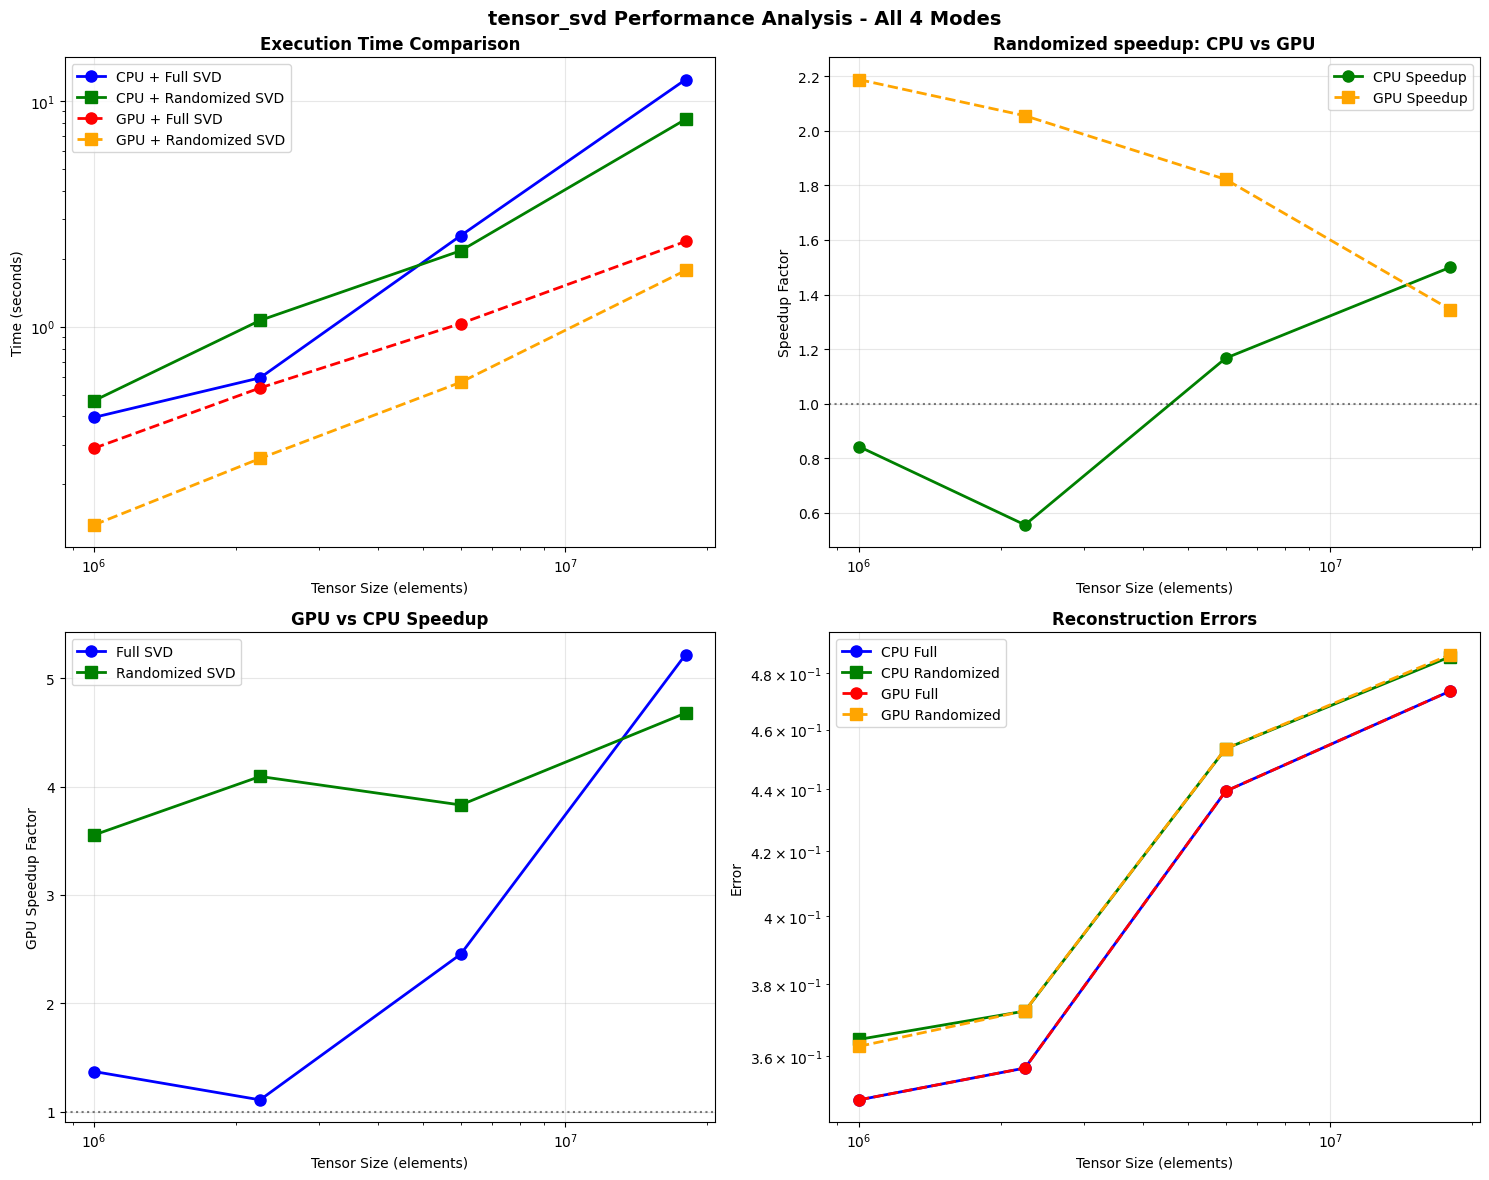

In [15]:
tensor_shapes = [(100, 100, 100),
                 (150, 150, 100), 
                 (200, 200, 150), 
                 (300, 300, 200)]
target_rank = 50

results = svd_test_fix_rank(tensor_shapes, target_rank)

In [16]:
# Binary tree Truncation

def svd_test_binary_tree(ttn: TreeTensorNetworkState,
                        max_bond_dim_list: list,
                        total_tol: float = 1e-6) -> list:

    results = []

    # outer progress bar
    for max_bond_dim in tqdm(max_bond_dim_list,
                             desc="Max bond dims",
                             unit="bond_dim",
                             position=0):
        entry = {
            "max_bond_dim": max_bond_dim,
            "cpu_full": {},
            "cpu_randomized": {},
            "gpu_randomized": {}
        }

        # inner progress bar for three truncations
        for trunc_mode in tqdm(["cpu_full", "gpu_randomized", "cpu_randomized"],
                               desc=f"Truncations @ bond_dim={max_bond_dim}",
                               leave=False,
                               position=1):
            if trunc_mode == "cpu_full":
                svd_params = SVDParameters(max_bond_dim=max_bond_dim,
                                           randomized_cutoff=float('inf'),
                                           total_tol=total_tol,
                                           sum_trunc=True)
                disable_gpu_acceleration()
                error, trunc_time = truncation_result(ttn, svd_params)
                entry["cpu_full"]["error"] = error
                entry["cpu_full"]["time"] = trunc_time

            elif trunc_mode == "gpu_randomized":
                svd_params = SVDParameters(max_bond_dim=float('inf'),
                                           randomized_cutoff=max_bond_dim,
                                           total_tol=total_tol,
                                           sum_trunc=True)
                enable_gpu_acceleration(threshold=10000, verbose=False)
                error, trunc_time = truncation_result(ttn, svd_params)
                entry["gpu_randomized"]["error"] = error
                entry["gpu_randomized"]["time"] = trunc_time

            elif trunc_mode == "cpu_randomized":
                svd_params = SVDParameters(max_bond_dim=float('inf'),
                                           randomized_cutoff=max_bond_dim,
                                           total_tol=total_tol,
                                           sum_trunc=True)
                disable_gpu_acceleration()
                error, trunc_time = truncation_result(ttn, svd_params)
                entry["cpu_randomized"]["error"] = error
                entry["cpu_randomized"]["time"] = trunc_time

        results.append(entry)
    
    return results

def plots_tree_truncation(results):
    """
    Plot TTN truncation benchmark:
    - Left: errors vs max_bond_dim
    - Right: speedup factors vs max_bond_dim
    """
    max_dims = [r["max_bond_dim"] for r in results]
    
    # Extract errors
    errors_cpu_full = [r["cpu_full"]["error"] for r in results]
    errors_cpu_rand = [r["cpu_randomized"]["error"] for r in results]
    errors_gpu_rand = [r["gpu_randomized"]["error"] for r in results]

    # Extract times
    times_cpu_full = [r["cpu_full"]["time"] for r in results]
    times_cpu_rand = [r["cpu_randomized"]["time"] for r in results]
    times_gpu_rand = [r["gpu_randomized"]["time"] for r in results]

    # Compute speedups
    speedup_cpu = [t_full / t_rand for t_full, t_rand in zip(times_cpu_full, times_cpu_rand)]
    speedup_gpu = [t_full / t_rand for t_full, t_rand in zip(times_cpu_full, times_gpu_rand)]
    
    # --- Create figure ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle("TTN Truncation Benchmark (Randomized SVD)", fontsize=14, fontweight="bold")

    # --- Left: Errors ---
    ax1.set_title("Reconstruction Error vs Max Bond Dim")
    ax1.plot(max_dims, errors_cpu_full, "o-", label="CPU Full SVD", linewidth=2)
    ax1.plot(max_dims, errors_cpu_rand, "s-", label="CPU Randomized", linewidth=2)
    ax1.plot(max_dims, errors_gpu_rand, "d-", label="GPU Randomized", linewidth=2)
    ax1.set_xlabel("Max Bond Dimension")
    ax1.set_ylabel("Error")
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # --- Right: Speedups ---
    ax2.set_title("Speedup vs Max Bond Dim")
    ax2.plot(max_dims, speedup_cpu, "s-", label="CPU-randomized", linewidth=2)
    ax2.plot(max_dims, speedup_gpu, "d-", label="GPU-randomized", linewidth=2)
    ax2.set_xlabel("Max Bond Dimension")
    ax2.set_ylabel("Speedup Factor")
    ax2.set_xscale("log")
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=1, color="black", linestyle=":", alpha=0.5)
    ax2.legend()

    plt.tight_layout()
    plt.show()


Max bond dims: 100%|██████████| 4/4 [10:54<00:00, 163.75s/bond_dim]


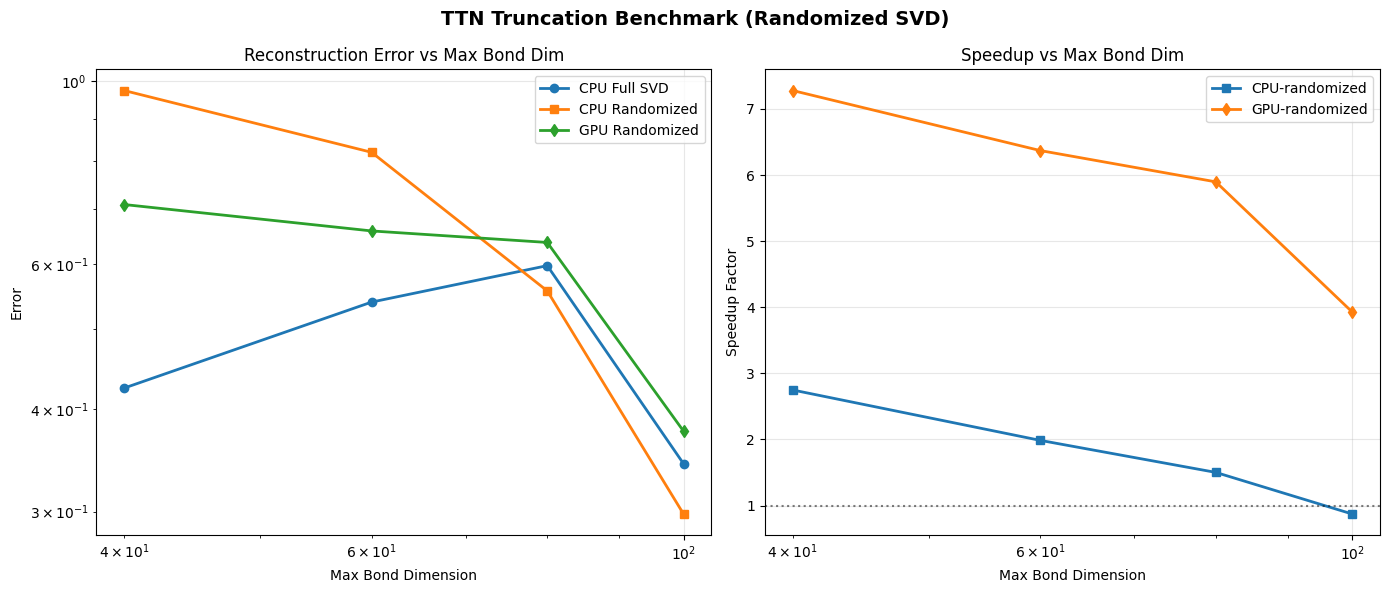

In [18]:
structure_name = "Binary tree"
num_phys = 20
bond_dim = 200
phys_tensor = np.array([1, 0], dtype=np.complex128)
binary_ttn = generate_binary_ttns(num_phys=num_phys, bond_dim=bond_dim, phys_tensor=phys_tensor)
binary_ttn = generate_random_ttn(binary_ttn,
                                large_scale=10,
                                small_scale=1e-8,
                                decay_rate=1)

max_product_dim_list = [40, 60, 80, 100]
results = svd_test_binary_tree(binary_ttn,
                                max_product_dim_list,
                                total_tol=0)
plots_tree_truncation(results)
